# **monolithic** *fiber*

In [ ]:
import numpy as np
import openseespy.opensees as op
import pandas as pd
import os


op.wipe()
op.model('basic', '-ndm', 3, '-ndf', 6)

seg_d   = 0.6  # diameter of segment
rebar_d = 0.02  # diameter of rebar
seg_len = 0.8  # length of each segment
tendon  = [1.36e-3, 0.1]
grout   = True  # grout or not
ini_f   = tendon[1] * seg_d ** 2 * np.pi / 4 * 40 * 0.667 / 1.4 * 1000 # initial force in tendon
ini_s   = ini_f / tendon[0]

op.node(1, 0, 0, 0)  # footing base
op.node(2, 0, 0, 0.6)  # footing top
# op.node(102, 0, 0, 0.6)  # column bottom
op.node(3, 0, 0, 0.6 + seg_len)  # joint_1_1
# op.node(103, 0, 0, 0.6 + seg_len)  # joint_1_2
op.node(4, 0, 0, 0.6 + 2 * seg_len)  # joint_2_1
# op.node(104, 0, 0, 0.6 + 2 * seg_len)  # joint_2_2
op.node(5, 0, 0, 0.6 + 3 * seg_len)  # joint_3_1
# op.node(105, 0, 0, 0.6 + 3 * seg_len)  # joint_3_2
op.node(6, 0, 0, 1.2 + 3 * seg_len)  # cap top

# op.node(201, 0, 0, 0)
# op.node(202, 0, 0, 0.6)
# op.node(203, 0, 0, 0.6 + seg_len)
# op.node(204, 0, 0, 0.6 + 2 * seg_len)
# op.node(205, 0, 0, 0.6 + 3 * seg_len)
# op.node(206, 0, 0, 1.2 + 3 * seg_len)



op.fix(1, 1, 1, 1, 1, 1, 1)

# constraint achor
# op.equalDOF(1, 201, 1, 2, 3, 4, 5, 6)
# op.equalDOF(6, 206, 1, 2, 3, 4, 5, 6)

# constraint duct
# if grout:
#     op.equalDOF(2, 202, 1, 2, 3, 4, 5, 6)
#     op.equalDOF(3, 203, 1, 2, 3, 4, 5, 6)
#     op.equalDOF(4, 204, 1, 2, 3, 4, 5, 6)
#     op.equalDOF(5, 205, 1, 2, 3, 4, 5, 6)
# else:
#     op.equalDOF(2, 202, 1, 2)
#     op.equalDOF(3, 203, 1, 2)
#     op.equalDOF(4, 204, 1, 2)
#     op.equalDOF(5, 205, 1, 2)

op.uniaxialMaterial('Concrete01', 1, -26800, -0.002, -22780, -0.004)  # cover concrete
op.uniaxialMaterial('Concrete01', 2, -48980, -0.006, -31600, -0.012)  # core concrete
op.uniaxialMaterial('Steel02', 3, 4.0e5, 2.0e8, 0.001, 9, 0.925, 0.15)  # steel rebar
op.uniaxialMaterial('Steel02', 4, 1.86e6, 1.95e8, 0.0001, 9, 0.925, 0.15, 0, 1, 0, ini_s)  # tendon
op.uniaxialMaterial('Elastic', 5, 3.015e7)

cover  = 0.02  # cover concrete thickness
core_d = seg_d - 2 * cover  # core concrete diameter
num_d  = 10  # subdivision number along diameter direction
num_t  = 10  # subdivision number along diameter perpendicular direction
num_r  = 14  # number of steel rebars
area   = rebar_d ** 2 * np.pi / 4  # area of rebar

op.section('Fiber', 1, '-GJ', 1e7)
op.patch('circ', 1, num_t, 1, 0, 0, core_d / 2, seg_d / 2, 0, 360)
op.patch('circ', 2, num_t, num_d, 0, 0, 0, core_d / 2, 0, 360)
op.layer('circ', 3, num_r, area, 0, 0, core_d / 2 - rebar_d / 2)

op.section('Fiber', 2, '-GJ', 1e7)
op.patch('circ', 2, num_t, 1, 0, 0, core_d / 2, seg_d / 2, 0, 360)
op.patch('circ', 2, num_t, num_d, 0, 0, 0, core_d / 2, 0, 360)

# op.section('Aggregator', 101, 5, 'Vy', 5, 'Vz', 5, 'T', 1)
op.beamIntegration('Lobatto', 1, 1, 5)
op.beamIntegration('Lobatto', 2, 2, 5)

op.geomTransf('Linear', 1, 1.0, 0.0, 0.0)

op.element('forceBeamColumn', 2, 2, 3, 1, 1)
op.element('forceBeamColumn', 3, 3, 4, 1, 1)
op.element('forceBeamColumn', 4, 4, 5, 1, 1)

# op.element('forceBeamColumn', 2, 102, 3, 1, 1)
# op.element('forceBeamColumn', 3, 103, 4, 1, 1)
# op.element('forceBeamColumn', 4, 104, 5, 1, 1)

op.element('elasticBeamColumn', 1, 1, 2, 2.25, 3.25e7, 6.5e6, 0.84, 0.42, 0.42, 1)

op.element('elasticBeamColumn', 5, 5, 6, 0.64, 3.25e7, 6.5e6, 0.068, 0.034, 0.034, 1)
# op.element('elasticBeamColumn', 5, 105, 6, 0.64, 3.25e7, 6.5e6, 0.068, 0.034, 0.034, 1)

# op.element('zeroLengthSection', 102, 2, 102, 2, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLengthSection', 103, 3, 103, 2, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLengthSection', 104, 4, 104, 2, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLengthSection', 105, 5, 105, 2, '-orient', 0, 0, 1, 1, 0, 0)
# tendon element
# op.element('Truss', 201, 201, 202, tendon[0], 4)
# op.element('Truss', 202, 202, 203, tendon[0], 4)
# op.element('Truss', 203, 203, 204, tendon[0], 4)
# op.element('Truss', 204, 204, 205, tendon[0], 4)
# op.element('Truss', 205, 205, 206, tendon[0], 4)

disp_file = '../data/output/quasi_static/6mono.out'
op.recorder('Node', '-file', disp_file, '-time', '-node', 6, '-dof', 1, 'disp')
op.record()

op.wipeAnalysis()
op.timeSeries('Linear', 1)
op.pattern('Plain', 1, 1)
op.load(6, 0, 0, -200, 0, 0, 0)
op.integrator('LoadControl', 0.1)
op.system('SparseGeneral')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('Plain')
op.constraints('Plain')
op.algorithm('Newton')
op.analysis('Static')
ok = op.analyze(10)
if ok != 0:
    print('\033[1;37;41m####<axial load Failed!>####\033[0m\n')
else:
    print('\033[1;37;42m####<axial load Succeed!>####\033[0m\n')

op.loadConst('-time', 0.0)

op.timeSeries('Linear', 2)
op.pattern('Plain', 2, 2)
op.load(6, 1, 0, 0, 0, 0, 0)
op.system('SparseGeneral', '-piv')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('Plain')
op.constraints('Plain')
op.algorithm('Newton')
op.analysis('Static')
for i in range(20):
    op.integrator('DisplacementControl', 6, 1, 0.001)
    ok1=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 6, 1, -0.001)
    ok2=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 6, 1, -0.001)
    ok3=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 6, 1, 0.001)
    ok4=op.analyze(10 * (i + 1))
    if (ok1 + ok2 + ok3 + ok4) != 0:
    # if ok1 != 0:
        print('\033[1;37;41m####<No.{} step Failed!>####\033[0m\n'.format(i + 1))
    else:
        print('\033[1;37;42m####<No.{} step Succeed!>####\033[0m\n'.format(i + 1))

# **Test** *seam*

In [7]:
import numpy as np
import openseespy.opensees as op
import pandas as pd
import os


op.wipe()
op.model('basic', '-ndm', 3, '-ndf', 6)

seg_d     = 0.6  # diameter of segment
rebar_d   = 0.01  # diameter of rebar
seg_len   = 0.8  # length of each segment
tendon    = [1.35e-3, 0.1]
grout     = False  # grout or not
dissapate = False
ini_f     = tendon[1] * seg_d ** 2 * np.pi / 4 * 40 * 0.667 / 1.4 * 1000 # initial force in tendon
ini_s     = ini_f / tendon[0]

op.node(1, 0, 0, 0)  # footing base
op.node(2, 0, 0, 0.6)  # footing top
op.node(102, 0, 0, 0.6 + 0.001)  # column bottom
op.node(3, 0, 0, 0.6 + seg_len)  # joint_1_1
op.node(103, 0, 0, 0.6 + seg_len + 0.001)  # joint_1_2
op.node(4, 0, 0, 0.6 + 2 * seg_len)  # joint_2_1
op.node(104, 0, 0, 0.6 + 2 * seg_len + 0.001)  # joint_2_2
op.node(5, 0, 0, 0.6 + 3 * seg_len)  # joint_3_1
op.node(105, 0, 0, 0.6 + 3 * seg_len + 0.001)  # joint_3_2
op.node(6, 0, 0, 1.2 + 3 * seg_len)  # cap top

op.node(201, 0, 0, 0)
op.node(202, 0, 0, 0.6)
op.node(203, 0, 0, 0.6 + seg_len)
op.node(204, 0, 0, 0.6 + 2 * seg_len)
op.node(205, 0, 0, 0.6 + 3 * seg_len)
op.node(206, 0, 0, 1.2 + 3 * seg_len)

# dissapation rebar(if necessary)
if dissapate:
    op.node(301, seg_d / 4, 0, 0)
    op.node(302, seg_d / 4, 0, 0.6)
    op.node(303, seg_d / 4, 0, 0.6 + seg_len)
    op.node(304, seg_d / 4, 0, 0.6 + 2 * seg_len)

    op.node(401, -seg_d / 4, 0, 0)
    op.node(402, -seg_d / 4, 0, 0.6)
    op.node(403, -seg_d / 4, 0, 0.6 + seg_len)
    op.node(404, -seg_d / 4, 0, 0.6 + 2 * seg_len)

op.fix(1, 1, 1, 1, 1, 1, 1)

# constraint achor
op.equalDOF(1, 201, 1, 2, 3, 4, 5, 6)
op.equalDOF(6, 206, 1, 2, 3, 4, 5, 6)

# constraint duct
if grout:
    op.equalDOF(2, 202, 1, 2, 3, 4, 5, 6)
    op.equalDOF(3, 203, 1, 2, 3, 4, 5, 6)
    op.equalDOF(4, 204, 1, 2, 3, 4, 5, 6)
    op.equalDOF(5, 205, 1, 2, 3, 4, 5, 6)
else:
    op.equalDOF(2, 202, 1, 2, 4, 5, 6)
    op.equalDOF(3, 203, 1, 2, 4, 5, 6)
    op.equalDOF(4, 204, 1, 2, 4, 5, 6)
    op.equalDOF(5, 205, 1, 2, 4, 5, 6)

# constraint dissapate(if necessary)
if dissapate:
    op.equalDOF(1, 301, 1, 2, 3, 4, 5, 6)
    op.equalDOF(2, 302, 1, 2, 4, 5, 6)
    op.equalDOF(3, 303, 1, 2, 4, 5, 6)
    op.equalDOF(4, 304, 1, 2, 3, 4, 5, 6)

    op.equalDOF(1, 401, 1, 2, 3, 4, 5, 6)
    op.equalDOF(2, 402, 1, 2, 4, 5, 6)
    op.equalDOF(3, 403, 1, 2, 4, 5, 6)
    op.equalDOF(4, 404, 1, 2, 3, 4, 5, 6)
# TODO DEFINE concrete
# op.uniaxialMaterial('Concrete01', 1, -26800, -0.002, -12278, -0.004)  # cover concrete
# op.uniaxialMaterial('Concrete01', 7, -48980, -0.012, -33160, -0.025)  # core concrete
op.uniaxialMaterial('Concrete01', 1, -26800, -0.002, -1000, -0.004)  # cover concrete
op.uniaxialMaterial('Concrete01', 2, -48980, -0.006, -33000, -0.012)  # core concrete
op.uniaxialMaterial('Steel02', 3, 4.0e5, 2.0e8, 0.0001, 9, 0.925, 0.15)  # steel rebar
op.uniaxialMaterial('Steel02', 4, 1.86e6, 1.95e8, 0.0001, 9, 0.925, 0.15, 0, 1, 0, ini_s)  # tendon
op.uniaxialMaterial('Elastic', 5, 1.95e8)
op.uniaxialMaterial('InitStressMaterial', 6, 5, ini_s)
op.uniaxialMaterial('ENT', 8, 3.25e7)

cover  = 0.02  # cover concrete thickness
core_d = seg_d - 2 * cover  # core concrete diameter
num_d  = 10  # subdivision number along diameter direction
num_t  = 10  # subdivision number along diameter perpendicular direction
num_r  = 14  # number of steel rebars
area   = rebar_d ** 2 * np.pi / 4  # area of rebar

op.section('Fiber', 1, '-GJ', 1e7)
op.patch('circ', 1, num_t, 1, 0, 0, core_d / 2, seg_d / 2, 0, 360)
op.patch('circ', 2, num_t, num_d, 0, 0, 0.025, core_d / 2, 0, 360)
op.layer('circ', 3, num_r, area, 0, 0, core_d / 2 - rebar_d / 2)

op.section('Fiber', 2, '-GJ', 1e7)
# op.patch('circ', 2, num_t, 1, 0, 0, core_d / 2, seg_d / 2, 0, 360)
op.patch('circ', 3, num_t, num_d, 0, 0, 0.025, seg_d / 2, 0, 360)
# op.layer('circ', 3, num_r, area, 0, 0, core_d / 2 - rebar_d / 2)


op.section('Aggregator', 101, 5, 'Vy', 5, 'Vz', 5, 'T', 1)
op.beamIntegration('Lobatto', 1, 1, 5)
op.beamIntegration('Lobatto', 102, 2, 5)

op.geomTransf('Linear', 1, 1.0, 0.0, 0.0)

op.element('forceBeamColumn', 2, 102, 3, 1, 1)
op.element('forceBeamColumn', 3, 103, 4, 1, 1)
op.element('forceBeamColumn', 4, 104, 5, 1, 1)

op.element('elasticBeamColumn', 1, 1, 2, 2.25, 3.25e7, 6.5e6, 0.84, 0.42, 0.42, 1)

op.element('forceBeamColumn', 102, 102, 2, 1, 102)
op.element('forceBeamColumn', 103, 103, 3, 1, 102)
op.element('forceBeamColumn', 104, 104, 4, 1, 102)
op.element('forceBeamColumn', 105, 105, 5, 1, 102)

# op.element('twoNodeLink', 102, 102, 2, '-mat', 8, '-dir', 1)
# op.element('twoNodeLink', 103, 103, 3, '-mat', 8, '-dir', 1)
# op.element('twoNodeLink', 104, 104, 4, '-mat', 8, '-dir', 1)
# op.element('twoNodeLink', 105, 105, 5, '-mat', 8, '-dir', 1)

op.element('elasticBeamColumn', 5, 105, 6, 0.64, 3.25e7, 6.5e6, 0.068, 0.034, 0.034, 1)

# op.element('zeroLengthSection', 102, 2, 102, 2, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLengthSection', 103, 3, 103, 2, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLengthSection', 104, 4, 104, 2, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLengthSection', 105, 5, 105, 2, '-orient', 0, 0, 1, 1, 0, 0)
# tendon element
op.element('Truss', 201, 201, 202, tendon[0], 6)
op.element('Truss', 202, 202, 203, tendon[0], 6)
op.element('Truss', 203, 203, 204, tendon[0], 6)
op.element('Truss', 204, 204, 205, tendon[0], 6)
op.element('Truss', 205, 205, 206, tendon[0], 6)

# dissapation bar
area_dis = (rebar_d * 2) ** 2 * np.pi / 4
if dissapate:
   op.element('Truss', 301, 301, 302, area_dis, 3)
   op.element('Truss', 302, 302, 303, area_dis, 3)
   op.element('Truss', 303, 303, 304, area_dis, 3)

   op.element('Truss', 401, 401, 402, area_dis, 3)
   op.element('Truss', 402, 402, 403, area_dis, 3)
   op.element('Truss', 403, 403, 404, area_dis, 3)

disp_file = '../data/output/quasi_static/6.out'
op.recorder('Node', '-file', disp_file, '-time', '-node', 6, '-dof', 1, 'disp')
op.record()

op.wipeAnalysis()
op.timeSeries('Linear', 1)
op.pattern('Plain', 1, 1)
op.load(6, 0, 0, -200, 0, 0, 0)
op.integrator('LoadControl', 0.1)
op.system('SparseGeneral')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('Plain')
op.constraints('Plain')
op.algorithm('Newton')
op.analysis('Static')
ok = op.analyze(10)
if ok != 0:
    print('\033[1;37;41m####<axial load Failed!>####\033[0m\n')
else:
    print('\033[1;37;42m####<axial load Succeed!>####\033[0m\n')

op.loadConst('-time', 0.0)

op.timeSeries('Linear', 2)
op.pattern('Plain', 2, 2)
op.load(6, 1, 0, 0, 0, 0, 0)
op.system('SparseGeneral', '-piv')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('Plain')
op.constraints('Plain')
op.algorithm('Newton')
op.analysis('Static')
for i in range(20):
    op.integrator('DisplacementControl', 6, 1, 0.001)
    ok1=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 6, 1, -0.001)
    ok2=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 6, 1, -0.001)
    ok3=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 6, 1, 0.001)
    ok4=op.analyze(10 * (i + 1))
    if (ok1 + ok2 + ok3 + ok4) != 0:
    # if ok1 != 0:
        print('\033[1;37;41m####<No.{} step Failed!>####\033[0m\n'.format(i + 1))
    else:
        print('\033[1;37;42m####<No.{} step Succeed!>####\033[0m\n'.format(i + 1))

####<axial load Succeed!>####

####<No.1 step Succeed!>####

####<No.2 step Succeed!>####

####<No.3 step Succeed!>####



WARNING can't set handler after analysis is created


####<No.4 step Succeed!>####

####<No.5 step Succeed!>####

####<No.6 step Succeed!>####

####<No.7 step Succeed!>####

####<No.8 step Succeed!>####

####<No.9 step Succeed!>####

####<No.10 step Succeed!>####

####<No.11 step Succeed!>####

####<No.12 step Succeed!>####

####<No.13 step Succeed!>####

####<No.14 step Succeed!>####

####<No.15 step Succeed!>####

####<No.16 step Succeed!>####

####<No.17 step Succeed!>####

####<No.18 step Succeed!>####

####<No.19 step Succeed!>####

####<No.20 step Succeed!>####



# **Test** *new*

In [ ]:
import numpy as np
import openseespy.opensees as op
import pandas as pd
import os


op.wipe()
op.model('basic', '-ndm', 3, '-ndf', 6)

seg_d     = 0.6  # diameter of segment
rebar_d   = 0.02  # diameter of rebar
seg_len   = 0.8  # length of each segment
tendon    = [1.35e-3, 0.1]  # TODO NEED consideration
ini_f     = tendon[1] * seg_d ** 2 * np.pi / 4 * 40 * 0.667 / 1.4 * 1000 # initial force in tendon
ini_s     = ini_f / tendon[0]

# pier
op.node(1, 0, 0, 0.6)
op.node(2, 0, 0, 0.6 + seg_len)
# op.node(3, 0, 0, 0.6 + 2 * seg_len)
op.node(4, 0, 0, 0.6 + 3 * seg_len)
# op.node(5, 0, 0, 1.2 + 3 * seg_len)

# op.node(22, 0, 0, 0.6 + seg_len)
# op.node(33, 0, 0, 0.6 + 2 * seg_len)
# op.node(44, 0, 0, 0.6 + 3 * seg_len)
# tendon
op.node(100, 0, 0, 0)
# op.node(101, 0, 0, 0.6)
# op.node(102, 0, 0, 0.6 + seg_len)
# op.node(103, 0, 0, 0.6 + 2 * seg_len)
op.node(104, 0, 0, 0.6 + 3 * seg_len)
# op.node(105, 0, 0, 1.2 + 3 * seg_len)
# dissapation rebar
op.node(201, seg_d / 4, 0, 0.6 + seg_len / 2)
op.node(202, seg_d / 4, 0, 0.6 + seg_len)
op.node(203, -seg_d / 4, 0, 0.6 + seg_len / 2)
op.node(204, -seg_d / 4, 0, 0.6 + seg_len)
# spring
op.node(301, -0.6, 0, 0.6)
op.node(302, -0.4, 0, 0.6)
op.node(303, -0.2, 0, 0.6)
op.node(304, 0, 0, 0.6)
op.node(305, 0.2, 0, 0.6)
op.node(306, 0.4, 0, 0.6)
op.node(307, 0.6, 0, 0.6)
op.node(311, -0.6, 0, 0.6)
op.node(312, -0.4, 0, 0.6)
op.node(313, -0.2, 0, 0.6)
op.node(314, 0, 0, 0.6)
op.node(315, 0.2, 0, 0.6)
op.node(316, 0.4, 0, 0.6)
op.node(317, 0.6, 0, 0.6)
# 
# op.node(401, -0.6, 0, 1.4)
# op.node(402, -0.4, 0, 1.4)
# op.node(403, -0.2, 0, 1.4)
# op.node(404, 0, 0, 1.4)
# op.node(405, 0.2, 0, 1.4)
# op.node(406, 0.4, 0, 1.4)
# op.node(407, 0.6, 0, 1.4)
# op.node(411, -0.6, 0, 1.4)
# op.node(412, -0.4, 0, 1.4)
# op.node(413, -0.2, 0, 1.4)
# op.node(414, 0, 0, 1.4)
# op.node(415, 0.2, 0, 1.4)
# op.node(416, 0.4, 0, 1.4)
# op.node(417, 0.6, 0, 1.4)
# 
# op.node(501, -0.6, 0, 2.2)
# op.node(502, -0.4, 0, 2.2)
# op.node(503, -0.2, 0, 2.2)
# op.node(504, 0, 0, 2.2)
# op.node(505, 0.2, 0, 2.2)
# op.node(506, 0.4, 0, 2.2)
# op.node(507, 0.6, 0, 2.2)
# op.node(511, -0.6, 0, 2.2)
# op.node(512, -0.4, 0, 2.2)
# op.node(513, -0.2, 0, 2.2)
# op.node(514, 0, 0, 2.2)
# op.node(515, 0.2, 0, 2.2)
# op.node(516, 0.4, 0, 2.2)
# op.node(517, 0.6, 0, 2.2)
# 
# op.node(601, -0.6, 0, 3.0)
# op.node(602, -0.4, 0, 3.0)
# op.node(603, -0.2, 0, 3.0)
# op.node(604, 0, 0, 3.0)
# op.node(605, 0.2, 0, 3.0)
# op.node(606, 0.4, 0, 3.0)
# op.node(607, 0.6, 0, 3.0)
# op.node(611, -0.6, 0, 3.0)
# op.node(612, -0.4, 0, 3.0)
# op.node(613, -0.2, 0, 3.0)
# op.node(614, 0, 0, 3.0)
# op.node(615, 0.2, 0, 3.0)
# op.node(616, 0.4, 0, 3.0)
# op.node(617, 0.6, 0, 3.0)

op.fix(100, 1, 1, 1, 1, 1, 1)
op.fix(201, 1, 1, 1, 1, 1, 1)
op.fix(203, 1, 1, 1, 1, 1, 1)
op.fix(301, 1, 1, 1, 1, 1, 1)
op.fix(302, 1, 1, 1, 1, 1, 1)
op.fix(303, 1, 1, 1, 1, 1, 1)
op.fix(304, 1, 1, 1, 1, 1, 1)
op.fix(305, 1, 1, 1, 1, 1, 1)
op.fix(306, 1, 1, 1, 1, 1, 1)
op.fix(307, 1, 1, 1, 1, 1, 1)

# constraint achor
op.rigidLink('beam', 4, 104)

op.rigidLink('beam', 2, 202)
op.rigidLink('beam', 2, 204)

op.rigidLink('beam', 1, 311)
op.rigidLink('beam', 1, 312)
op.rigidLink('beam', 1, 313)
op.rigidLink('beam', 1, 314)
op.rigidLink('beam', 1, 315)
op.rigidLink('beam', 1, 316)
op.rigidLink('beam', 1, 317)

# op.rigidLink('beam', 2, 401)
# op.rigidLink('beam', 2, 402)
# op.rigidLink('beam', 2, 403)
# op.rigidLink('beam', 2, 404)
# op.rigidLink('beam', 2, 405)
# op.rigidLink('beam', 2, 406)
# op.rigidLink('beam', 2, 407)

# op.rigidLink('beam', 22, 411)
# op.rigidLink('beam', 22, 412)
# op.rigidLink('beam', 22, 413)
# op.rigidLink('beam', 22, 414)
# op.rigidLink('beam', 22, 415)
# op.rigidLink('beam', 22, 416)
# op.rigidLink('beam', 22, 417)

# op.rigidLink('beam', 3, 501)
# op.rigidLink('beam', 3, 502)
# op.rigidLink('beam', 3, 503)
# op.rigidLink('beam', 3, 504)
# op.rigidLink('beam', 3, 505)
# op.rigidLink('beam', 3, 506)
# op.rigidLink('beam', 3, 507)

# op.rigidLink('beam', 33, 511)
# op.rigidLink('beam', 33, 512)
# op.rigidLink('beam', 33, 513)
# op.rigidLink('beam', 33, 514)
# op.rigidLink('beam', 33, 515)
# op.rigidLink('beam', 33, 516)
# op.rigidLink('beam', 33, 517)

# op.rigidLink('beam', 4, 601)
# op.rigidLink('beam', 4, 602)
# op.rigidLink('beam', 4, 603)
# op.rigidLink('beam', 4, 604)
# op.rigidLink('beam', 4, 605)
# op.rigidLink('beam', 4, 606)
# op.rigidLink('beam', 4, 607)

# op.rigidLink('beam', 44, 611)
# op.rigidLink('beam', 44, 612)
# op.rigidLink('beam', 44, 613)
# op.rigidLink('beam', 44, 614)
# op.rigidLink('beam', 44, 615)
# op.rigidLink('beam', 44, 616)
# op.rigidLink('beam', 44, 617)


# TODO DEFINE concrete
op.uniaxialMaterial('Steel02', 3, 4.0e5, 2.0e8, 0.0001, 9, 0.925, 0.15)  # steel rebar
# op.uniaxialMaterial('Steel02', 4, 1.86e6, 1.95e8, 0.0001, 9, 0.925, 0.15, 0, 1, 0, ini_s)  # tendon
op.uniaxialMaterial('Elastic', 5, 1.95e7)
op.uniaxialMaterial('InitStressMaterial', 6, 5, ini_s)
op.uniaxialMaterial('ENT', 8, 1.3e6)

op.geomTransf('Linear', 1, 1.0, 0.0, 0.0)

op.element('elasticBeamColumn', 1, 1, 2, 0.28, 3.25e7, 6.5e6, 0.004, 0.002, 0.002, 1)
op.element('elasticBeamColumn', 2, 2, 4, 0.28, 3.25e7, 6.5e6, 0.004, 0.002, 0.002, 1)
# op.element('elasticBeamColumn', 3, 33, 4, 0.28, 3.25e7, 6.5e6, 0.004, 0.002, 0.002, 1)
# op.element('elasticBeamColumn', 4, 44, 5, 0.64, 3.25e7, 6.5e6, 0.068, 0.034, 0.034, 1)

# tendon element
op.element('Truss', 100, 100, 104, tendon[0], 5)
# op.element('Truss', 101, 101, 102, tendon[0], 6)
# op.element('Truss', 102, 102, 103, tendon[0], 6)
# op.element('Truss', 103, 103, 104, tendon[0], 6)
# op.element('Truss', 104, 104, 105, tendon[0], 6)

# dissapation bar
area_dis = 0.04 ** 2 * np.pi / 4
op.element('Truss', 201, 201, 202, area_dis, 3)
op.element('Truss', 203, 203, 204, area_dis, 3)

# spring
op.element('zeroLength', 301, 301, 311, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 302, 302, 312, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 303, 303, 313, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 304, 304, 314, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 305, 305, 315, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 306, 306, 316, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 307, 307, 317, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)

# op.element('zeroLength', 401, 401, 411, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 402, 402, 412, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 403, 403, 413, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 404, 404, 414, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 405, 405, 415, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 406, 406, 416, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 407, 407, 417, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)

# op.element('zeroLength', 501, 501, 511, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 502, 502, 512, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 503, 503, 513, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 504, 504, 514, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 505, 505, 515, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 506, 506, 516, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 507, 507, 517, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)

# op.element('zeroLength', 601, 601, 611, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 602, 602, 612, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 603, 603, 613, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 604, 604, 614, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 605, 605, 615, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 606, 606, 616, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)
# op.element('zeroLength', 607, 607, 617, '-mat', 8, 5, 5, 5, 5, 5, '-dir', 1, 2, 3, 4, 5, 6, '-orient', 0, 0, 1, 1, 0, 0)


disp_file = '../data/output/quasi_static/4.out'
# op.recorder('Element', '-file', disp_file, '-time', '-ele', 201, 'axialForce')
op.recorder('Node', '-file', disp_file, '-time', '-node', 4, '-dof', 1, 'disp')
op.record()

op.wipeAnalysis()
op.timeSeries('Linear', 1)
op.pattern('Plain', 1, 1)
op.load(4, 0, 0, -200, 0, 0, 0)
op.integrator('LoadControl', 0.1)
op.system('SparseGeneral')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('RCM')
op.constraints('Transformation')
op.algorithm('KrylovNewton')
op.analysis('Static')
ok = op.analyze(10)
if ok != 0:
    print('\033[1;37;41m####<axial load Failed!>####\033[0m\n')
else:
    print('\033[1;37;42m####<axial load Succeed!>####\033[0m\n')

op.loadConst('-time', 0.0)

op.timeSeries('Linear', 2)
op.pattern('Plain', 2, 2)
op.load(4, 1, 0, 0, 0, 0, 0)
op.system('SparseGeneral', '-piv')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('RCM')
op.constraints('Transformation')
op.algorithm('KrylovNewton')
op.analysis('Static')
for i in range(20):
    op.integrator('DisplacementControl', 4, 1, 0.001)
    ok1=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 4, 1, -0.001)
    ok2=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 4, 1, -0.001)
    ok3=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 4, 1, 0.001)
    ok4=op.analyze(10 * (i + 1))
    if (ok1 + ok2 + ok3 + ok4) != 0:
    # if ok1 != 0:
        print('\033[1;37;41m####<No.{} step Failed!>####\033[0m\n'.format(i + 1))
    else:
        print('\033[1;37;42m####<No.{} step Succeed!>####\033[0m\n'.format(i + 1))

# **One** *Seam*

In [15]:
import numpy as np
import openseespy.opensees as op
import pandas as pd
import os


op.wipe()
op.model('basic', '-ndm', 3, '-ndf', 6)

seg_d     = 0.6  # diameter of segment
rebar_d   = 0.02  # diameter of rebar
seg_len   = 0.8  # length of each segment
tendon    = [1.35e-3 / 7, 0.1]  # TODO NEED consideration
ini_f     = tendon[1] * seg_d ** 2 * np.pi / 4 * 40 * 0.667 / 1.4 * 1000 # initial force in tendon
ini_s     = ini_f / tendon[0]

# pier
op.node(1, 0, 0, 0.6)
op.node(2, 0, 0, 0.6 + seg_len)
op.node(4, 0, 0, 0.6 + 3 * seg_len)

# tendon
op.node(100, 0, 0, 0)
op.node(104, 0, 0, 0.6 + 3 * seg_len)

# dissapation rebar
op.node(201, seg_d / 4, 0, 0.6 + seg_len / 2)
op.node(202, seg_d / 4, 0, 0.6 + seg_len)
op.node(203, -seg_d / 4, 0, 0.6 + seg_len / 2)
op.node(204, -seg_d / 4, 0, 0.6 + seg_len)
# spring
op.node(301, -0.6, 0, 0.6)
op.node(302, -0.4, 0, 0.6)
op.node(303, -0.2, 0, 0.6)
op.node(304, 0, 0, 0.6)
op.node(305, 0.2, 0, 0.6)
op.node(306, 0.4, 0, 0.6)
op.node(307, 0.6, 0, 0.6)
op.node(311, -0.6, 0, 0.6)
op.node(312, -0.4, 0, 0.6)
op.node(313, -0.2, 0, 0.6)
op.node(314, 0, 0, 0.6)
op.node(315, 0.2, 0, 0.6)
op.node(316, 0.4, 0, 0.6)
op.node(317, 0.6, 0, 0.6)

op.fix(100, 1, 1, 1, 1, 1, 1)
op.fix(201, 1, 1, 1, 1, 1, 1)
op.fix(203, 1, 1, 1, 1, 1, 1)
op.fix(301, 1, 1, 1, 1, 1, 1)
op.fix(302, 1, 1, 1, 1, 1, 1)
op.fix(303, 1, 1, 1, 1, 1, 1)
op.fix(304, 1, 1, 1, 1, 1, 1)
op.fix(305, 1, 1, 1, 1, 1, 1)
op.fix(306, 1, 1, 1, 1, 1, 1)
op.fix(307, 1, 1, 1, 1, 1, 1)

# constraint achor
op.rigidLink('beam', 4, 104)

op.rigidLink('beam', 2, 202)
op.rigidLink('beam', 2, 204)

op.rigidLink('beam', 1, 311)
op.rigidLink('beam', 1, 312)
op.rigidLink('beam', 1, 313)
op.rigidLink('beam', 1, 314)
op.rigidLink('beam', 1, 315)
op.rigidLink('beam', 1, 316)
op.rigidLink('beam', 1, 317)

# TODO DEFINE concrete
op.uniaxialMaterial('Steel02', 3, 4.0e5, 2.0e8, 0.001, 9, 0.925, 0.15)  # steel rebar
# op.uniaxialMaterial('Steel02', 4, 1.86e6, 1.95e8, 0.0001, 9, 0.925, 0.15, 0, 1, 0, ini_s)  # tendon
op.uniaxialMaterial('Elastic', 5, 1.95e10)
op.uniaxialMaterial('ElasticPP', 7, 1.95e8, .01, .01, 2e-3)
op.uniaxialMaterial('InitStressMaterial', 6, 5, ini_s)
op.uniaxialMaterial('ENT', 8, 1.3e5)

op.geomTransf('Linear', 1, 1.0, 0.0, 0.0)

op.element('elasticBeamColumn', 1, 1, 2, 0.28, 3.25e7, 6.5e6, 0.004, 0.002, 0.002, 1)
op.element('elasticBeamColumn', 2, 2, 4, 0.28, 3.25e7, 6.5e6, 0.004, 0.002, 0.002, 1)

# tendon element
op.element('Truss', 100, 100, 104, tendon[0], 7)
# op.element('Truss', 101, 101, 102, tendon[0], 6)
# op.element('Truss', 102, 102, 103, tendon[0], 6)
# op.element('Truss', 103, 103, 104, tendon[0], 6)
# op.element('Truss', 104, 104, 105, tendon[0], 6)

# dissapation bar
area_dis = 0.08 ** 2 * np.pi / 4
op.element('Truss', 201, 201, 202, area_dis, 3)
op.element('Truss', 203, 203, 204, area_dis, 3)

# spring
op.element('zeroLength', 301, 301, 311, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 302, 302, 312, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 303, 303, 313, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 304, 304, 314, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 305, 305, 315, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 306, 306, 316, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)
op.element('zeroLength', 307, 307, 317, '-mat', 8, 5, 5, '-dir', 1, 2, 3, '-orient', 0, 0, 1, 1, 0, 0)

disp_file = '../data/output/quasi_static/4.out'
# op.recorder('Element', '-file', disp_file, '-time', '-ele', 201, 'axialForce')
op.recorder('Node', '-file', disp_file, '-time', '-node', 4, '-dof', 1, 'disp')
op.record()

op.wipeAnalysis()
op.timeSeries('Linear', 1)
op.pattern('Plain', 1, 1)
op.load(4, 0, 0, -200, 0, 0, 0)
op.integrator('LoadControl', 0.1)
op.system('SparseGeneral')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('RCM')
op.constraints('Transformation')
op.algorithm('KrylovNewton')
op.analysis('Static')
ok = op.analyze(10)
if ok != 0:
    print('\033[1;37;41m####<axial load Failed!>####\033[0m\n')
else:
    print('\033[1;37;42m####<axial load Succeed!>####\033[0m\n')

op.loadConst('-time', 0.0)

op.timeSeries('Linear', 2)
op.pattern('Plain', 2, 2)
op.load(4, 1, 0, 0, 0, 0, 0)
op.system('SparseGeneral', '-piv')
op.test('NormDispIncr', 1.0e-4, 100, 0)
op.numberer('RCM')
op.constraints('Transformation')
op.algorithm('KrylovNewton')
op.analysis('Static')
for i in range(20):
    op.integrator('DisplacementControl', 4, 1, 0.001)
    ok1=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 4, 1, -0.001)
    ok2=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 4, 1, -0.001)
    ok3=op.analyze(10 * (i + 1))
    op.integrator('DisplacementControl', 4, 1, 0.001)
    ok4=op.analyze(10 * (i + 1))
    if (ok1 + ok2 + ok3 + ok4) != 0:
    # if ok1 != 0:
        print('\033[1;37;41m####<No.{} step Failed!>####\033[0m\n'.format(i + 1))
    else:
        print('\033[1;37;42m####<No.{} step Succeed!>####\033[0m\n'.format(i + 1))

ElasticPPMaterial::ElasticPPMaterial() - eyn > 0, setting < 0
WARNING can't set handler after analysis is created


####<axial load Succeed!>####

####<No.1 step Succeed!>####

####<No.2 step Succeed!>####

####<No.3 step Succeed!>####

####<No.4 step Succeed!>####

####<No.5 step Succeed!>####

####<No.6 step Succeed!>####

####<No.7 step Succeed!>####

####<No.8 step Succeed!>####

####<No.9 step Succeed!>####

####<No.10 step Succeed!>####

####<No.11 step Succeed!>####

####<No.12 step Succeed!>####

####<No.13 step Succeed!>####

####<No.14 step Succeed!>####

####<No.15 step Succeed!>####

####<No.16 step Succeed!>####

####<No.17 step Succeed!>####

####<No.18 step Succeed!>####

####<No.19 step Succeed!>####

####<No.20 step Succeed!>####



# **PLOT** *CONTRAST*

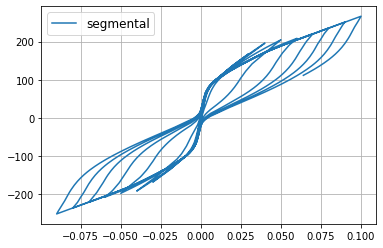

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# plt.rc(family='times new roman')
# f = pd.read_table('../data/output/quasi_static/4.out')
f = pd.read_table('../data/output/quasi_static/6.out')
b = []
for i in f.iloc[:, 0].to_numpy():
    b.append(i.split(' '))
force = []
disp  = []
for j in range(len(b) - 1):
    force.append(float(b[j][0]))
    disp.append(float(b[j][1]))
f1 = pd.read_table('../data/output/quasi_static/3.out')
b1 = []
for i in f1.iloc[:, 0].to_numpy():
    b1.append(i.split(' '))
force1 = []
disp1  = []
for j in range(len(b1) - 1):
    force1.append(float(b1[j][0]))
    disp1.append(float(b1[j][1]))
# plt.ylim(-200, 200)
# plt.plot(disp, force, label='monolithic')
plt.plot(disp1, force1,label='segmental')
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
a = '1 2'
b = a.split(' ')
b